## Standard Preprocessing Workflow and Basic Visualization

In [32]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tictoc))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(GEOquery))

In [15]:
expression_matrix <- ReadMtx(
    mtx = '/data/GSM7029390/GSM7029390_91_matrix.mtx.gz',
    features = '/data/GSM7029390/GSM7029390_91_features.tsv.gz',
    cells ='/data/GSM7029390/GSM7029390_91_barcodes.tsv.gz'
)
seurat_object <- CreateSeuratObject(counts = expression_matrix[!grepl('HTO',rownames(expression_matrix)),])
seurat_object

An object of class Seurat 
31053 features across 20446 samples within 1 assay 
Active assay: RNA (31053 features, 0 variable features)
 1 layer present: counts

In [16]:
# Normalize RNA data with log normalization
seurat_object <- NormalizeData(seurat_object)

# Find and scale variable features
seurat_object <- FindVariableFeatures(seurat_object, selection.method = "mean.var.plot")
seurat_object <- ScaleData(seurat_object, features = VariableFeatures(seurat_object))

Normalizing layer: counts

Finding variable features for layer data

Centering and scaling data matrix



In [20]:
# Add HTO data as a new assay independent from RNA
htos <- expression_matrix[grepl('HTO',rownames(expression_matrix)),]
seurat_object[["HTO"]] <- CreateAssayObject(counts = as.matrix(htos))

# Normalize HTO data, here we use centered log-ratio (CLR) transformation
seurat_object <- NormalizeData(seurat_object, assay = "HTO", normalization.method = "CLR")

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Normalizing across features



In [21]:
seurat_object <- HTODemux(seurat_object, assay = "HTO", positive.quantile = 0.99)
# Global classification results
table(seurat_object$HTO_classification.global)

As of Seurat v5, we recommend using AggregateExpression to perform pseudo-bulk analysis.
This message is displayed once per session.
First group.by variable `ident` starts with a number, appending `g` to ensure valid variable names
This message is displayed once every 8 hours.
Cutoff for HTO-1 : 59 reads

Cutoff for HTO-2 : 316 reads




 Doublet Negative  Singlet 
     410    13019     7017 

Picking joint bandwidth of 0.0368

Picking joint bandwidth of 0.0416



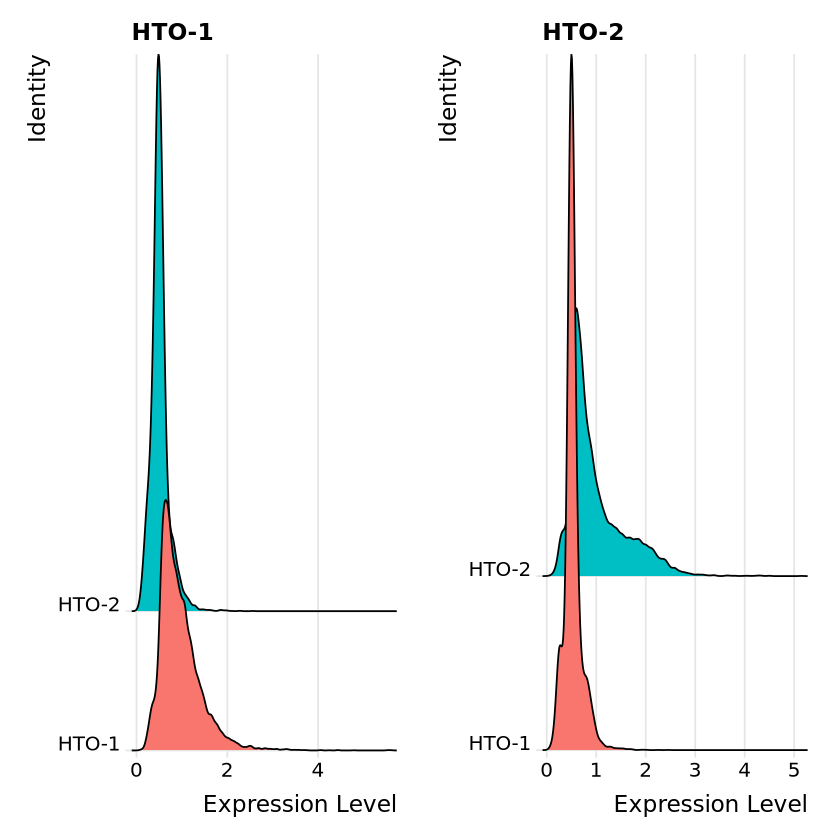

In [22]:
# Group cells based on the max HTO signal
Idents(seurat_object) <- "HTO_maxID"
RidgePlot(seurat_object, assay = "HTO", features = rownames(seurat_object[["HTO"]])[1:2], ncol = 2)

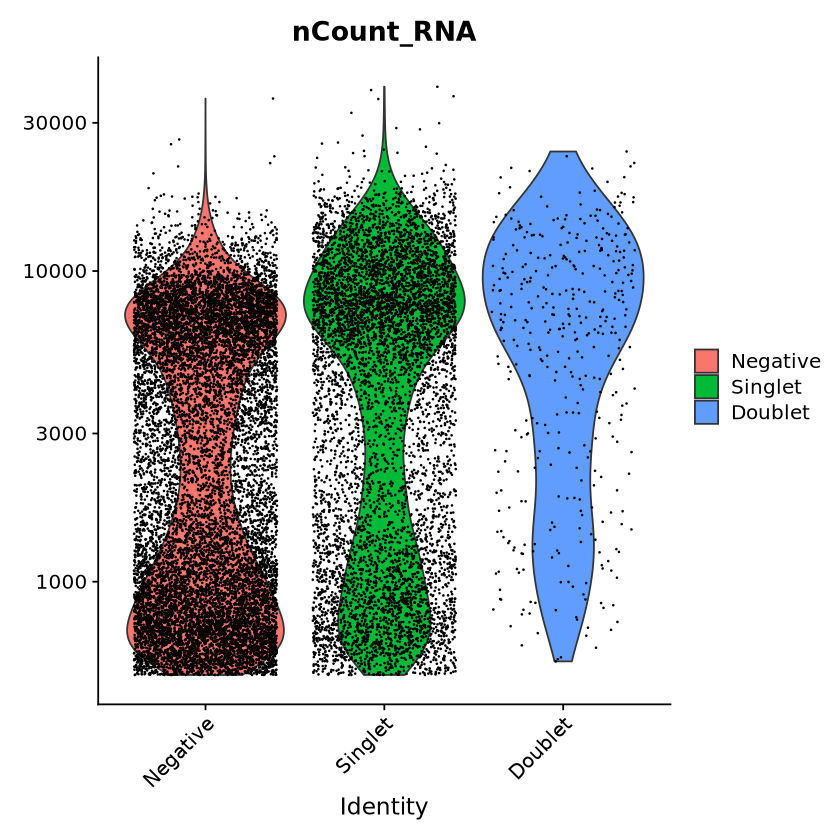

In [23]:
Idents(seurat_object) <- "HTO_classification.global"
VlnPlot(seurat_object, features = "nCount_RNA", pt.size = 0.1, log = TRUE)

In [24]:
Seuratobject <- DietSeurat(subset(seurat_object, subset = (HTO_classification.global == 'Singlet') ))

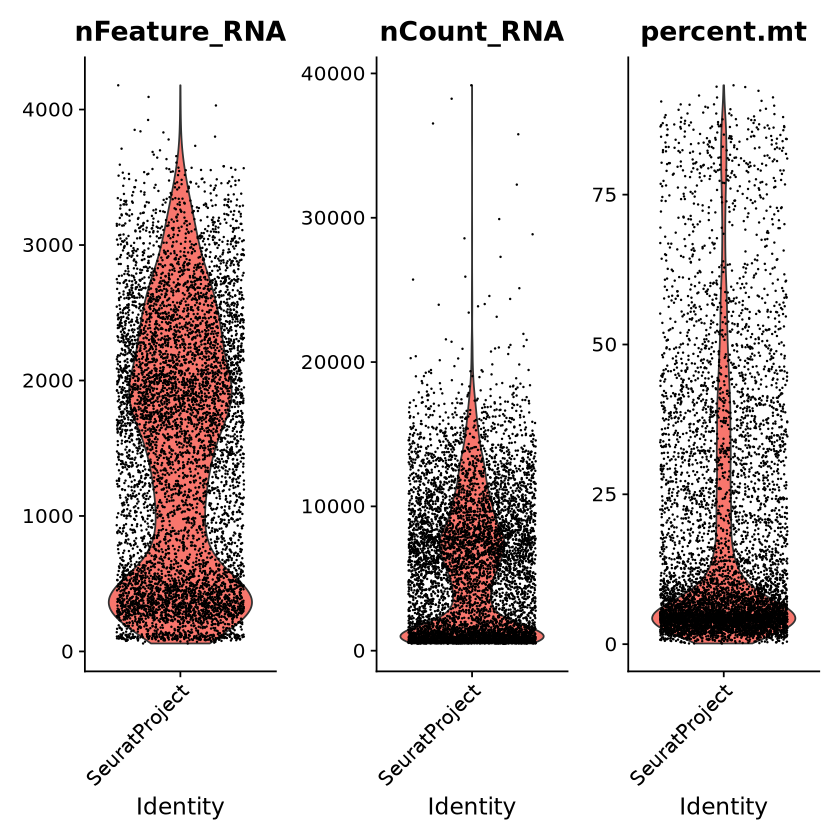

In [25]:
Seuratobject[["percent.mt"]] <- PercentageFeatureSet(Seuratobject, pattern = "^mt-") # mouse: "^mt-", human: "^MT-"
VlnPlot(Seuratobject, group.by = "orig.ident", features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

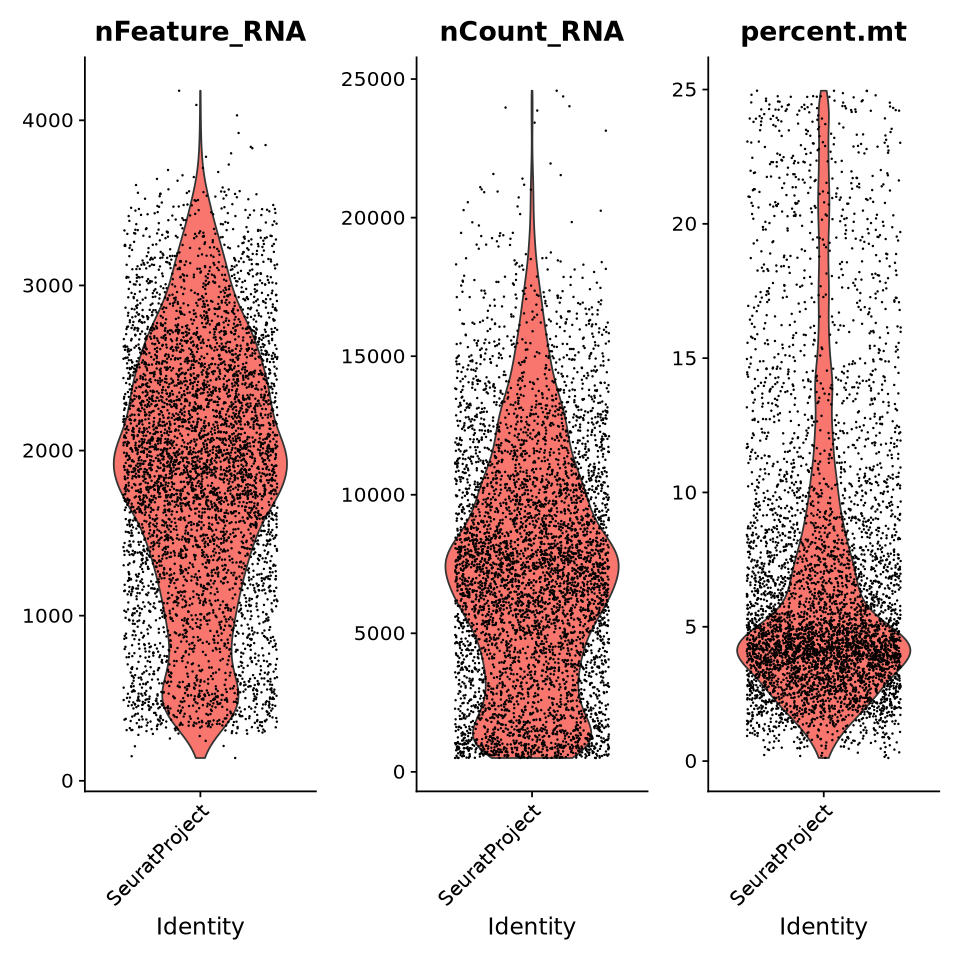

In [38]:
options(repr.plot.width=8, repr.plot.height=8)
Seuratobject <- subset(Seuratobject, subset = (nFeature_RNA > 100) & (nCount_RNA < 25000) & (percent.mt < 25))
VlnPlot(Seuratobject, group.by = "orig.ident",features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [40]:
Seuratobject <- Seuratobject %>% NormalizeData %>% FindVariableFeatures(nfeatures = 2000)

Seuratobject <- ScaleData(Seuratobject, features = rownames(Seuratobject))
Seuratobject <- RunPCA(Seuratobject, npcs = 15, features = VariableFeatures(object = Seuratobject))

Seuratobject <- Seuratobject %>% FindNeighbors(dims=1:15) %>% FindClusters(algorithm = 1, random.seed = 256)
Seuratobject <- Seuratobject %>% RunUMAP(dims=1:15)

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Warning message:
“Different features in new layer data than already exists for scale.data”
PC_ 1 
Positive:  Fabp2, Spink1, Apoc3, Apoa1, Aldob, Crip1, Clec2h, Guca2b, Mep1b, 2200002D01Rik 
	   Cyp4f14, Ms4a10, Acsl5, Creb3l3, Adh6a, Sult1b1, Cgref1, Ace, Mogat2, Papss2 
	   Cyp3a13, Ces2c, Tm6sf2, Tm4sf5, Cideb, Scp2, Dpep1, Lct, Aldh1a1, Cst6 
Negative:  Ifitm3, Mif, Npm1, Stmn1, Hmgn1, Tubb5, Ifitm2, Hmgb1, H2afz, Rbm3 
	   Hmgn2, Nhp2, Krt18, Anp32b, Ly6e, Snrpd1, Cd9, Tceal9, Hmgb2, Selenoh 
	   Fxyd3, Mmp7, Dut, Pclaf, Dek, Lyar, Marcksl1, Krt7, Lsm2, Hspe1 
PC_ 2 
Positive:  Pycard, Hspe1, Hmgb2, Cps1, Ccl25, Cks2, Csrp2, Ube2c, Pclaf, Cdca3 
	   Tk1, Spc24, H2afz, Clca3b, Lsm2, Hmgb1, Top2a, Hist1h2ap, Smc2, Pigr 
	   Cdk2ap2, Anp32b, Mki67, Snrpd1, Dut, Glod5, Cenpw, Dek, Npm1, Marc2 
Negative:  S100a6, Selenom, Reep5, Fxyd3, Tm4sf4, Krt18, Mmp7, Tff3, Clps, Zg16 
	   Muc2

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5214
Number of edges: 173159

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8729
Number of communities: 17
Elapsed time: 0 seconds


07:08:55 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

07:08:55 Read 5214 rows and found 15 numeric columns

07:08:55 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

07:08:55 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

07:08:56 Writing NN index file to temp file /tmp/RtmpQCW15H/file19df95fe21950

07:08:56 Searching Annoy index using 1 thread, search_k = 3000

07:08:58 Annoy recall = 100%

07:08:59 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

07:09:00 Initializing from normalized Laplacian + 

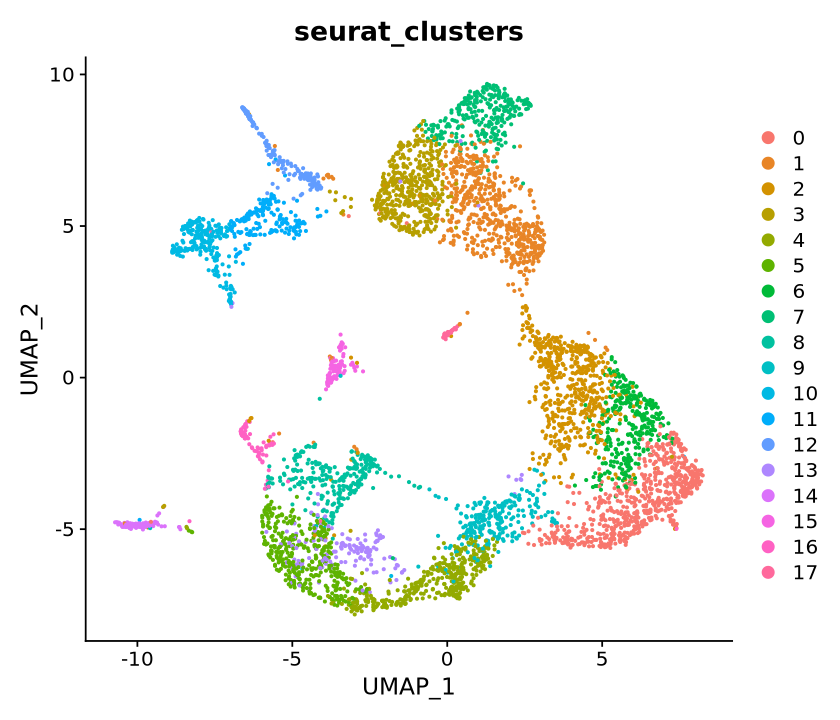

In [49]:
options(repr.plot.width=7, repr.plot.height=6)
DimPlot(Seuratobject, pt.size = 0.5, reduction = "umap", group.by = "seurat_clusters", label = FALSE)

## Dynamic Trajectory Inference : Slingshot

In [50]:
library(slingshot, quietly = FALSE)

Loading required package: princurve

Loading required package: TrajectoryUtils

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following objects are masked from ‘package:Biobase’:

    anyMissing, rowMedians


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds

In [52]:
sds <- slingshot(Embeddings(Seuratobject, "umap"), clusterLabels = Seuratobject$seurat_clusters, 
                 start.clus = 2, extend='n')

In [1]:
pt <- slingPseudotime(sds)
# slingLineages(sds)

In [54]:
# Assign a color to each cell based on some value

cell_pal <- function(cell_vars, pal_fun,...) {
  if (is.numeric(cell_vars)) {
    pal <- pal_fun(100, ...)
    return(pal[cut(cell_vars, breaks = 100)])
  } else {
    categories <- sort(unique(cell_vars))
    pal <- setNames(pal_fun(length(categories), ...), categories)
    return(pal[cell_vars])
  }
}

Warning message in plot.window(...):
“"label" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"label" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"label" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"label" is not a graphical parameter”
Warning message in box(...):
“"label" is not a graphical parameter”
Warning message in title(...):
“"label" is not a graphical parameter”


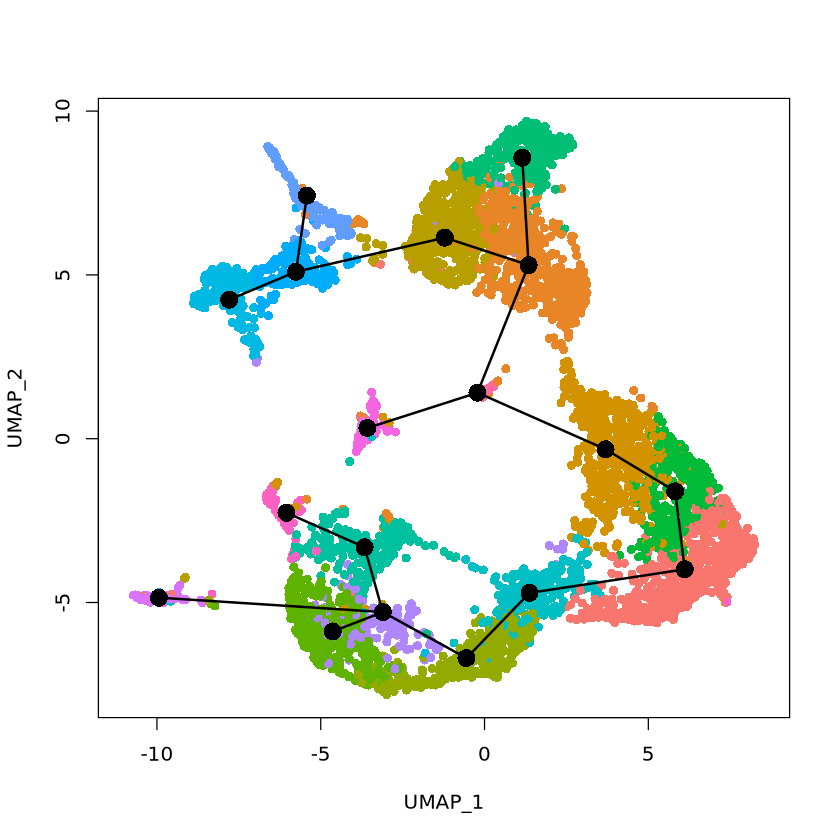

In [55]:
cell_colors_clust <- cell_pal(Seuratobject$seurat_clusters, scales::hue_pal())
options(repr.plot.width=7, repr.plot.height=7)
plot(Embeddings(Seuratobject, "umap"),col=cell_colors_clust, pch=16, asp = 1,label=TRUE)
lines(SlingshotDataSet(sds), lwd=2, type = 'lineages', col = 'black')